# Gaussian Lowpass Filter

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
img_path = '/Users/jeonhyeonbin/Library/Mobile Documents/com~apple~CloudDocs/POSTECH/계산사진학/assn1/assn2/images/cat.jpg'

In [3]:
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)/255.0
M, N = img.shape

 2) 경계 처리: 이미지 패딩(Zero-padding 예시)
    - 주파수 영역 필터링 시, (2M, 2N) 등으로 패딩하면
      wrap-around로 인한 경계 왜곡(bleeding)을 줄일 수 있음

In [4]:
P, Q = 2*M, 2*N  # 패딩 후 크기(2배)
padded = np.zeros((P, Q), dtype=img.dtype)
padded[:M, :N] = img  # 왼쪽 상단에 원본 이미지 복사

In [5]:
# --------------------------------------------------
# 3) DFT & Shift
# --------------------------------------------------
F = np.fft.fft2(padded)        # 2D DFT
F_shifted = np.fft.fftshift(F) # 저주파를 중심으로 shift

In [6]:
# --------------------------------------------------
# 4) 가우시안 & 이상적 저주파 통과 필터 정의
# --------------------------------------------------
def gaussian_lowpass_filter(shape, cutoff):
    """
    shape: (P, Q) 형태 (패딩된 이미지 크기)
    cutoff: 가우시안 표준편차(σ)
    """
    P, Q = shape
    # 주파수 좌표계 (u, v) 생성
    u = np.arange(P)
    v = np.arange(Q)
    U, V = np.meshgrid(u, v, indexing='ij')
    
    # 중심좌표(DC 성분)가 (P/2, Q/2)가 되도록
    center_u, center_v = P//2, Q//2
    dist_sq = (U - center_u)**2 + (V - center_v)**2
    
    # 가우시안 필터: H(u,v) = exp(- dist^2 / (2*sigma^2))
    H = np.exp(-dist_sq / (2 * (cutoff**2)))
    return H

def ideal_lowpass_filter(shape, cutoff):
    """
    shape: (P, Q) 형태
    cutoff: 차단 주파수 반경(D0)
    """
    P, Q = shape
    # 주파수 좌표계 (u, v) 생성
    u = np.arange(P)
    v = np.arange(Q)
    U, V = np.meshgrid(u, v, indexing='ij')
    
    # 중심좌표(DC 성분)가 (P/2, Q/2)가 되도록
    center_u, center_v = P//2, Q//2
    dist = np.sqrt((U - center_u)**2 + (V - center_v)**2)
    
    # 이상적 저주파 필터: dist <= cutoff 이면 1, 아니면 0
    H = np.zeros((P, Q), dtype=np.float32)
    H[dist <= cutoff] = 1.0
    return H

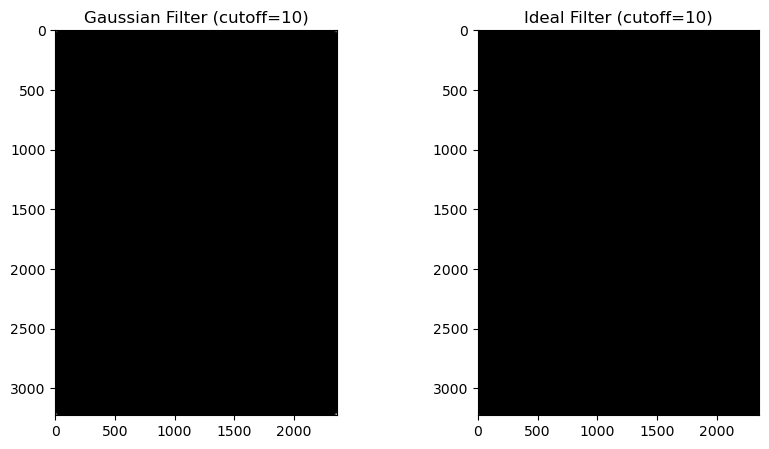

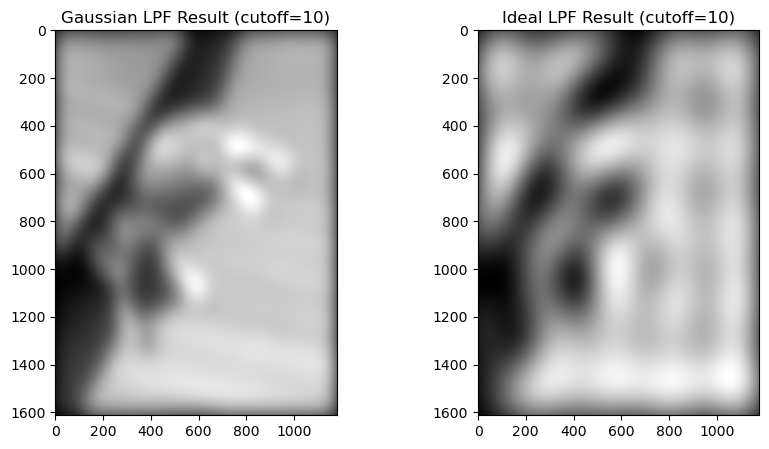

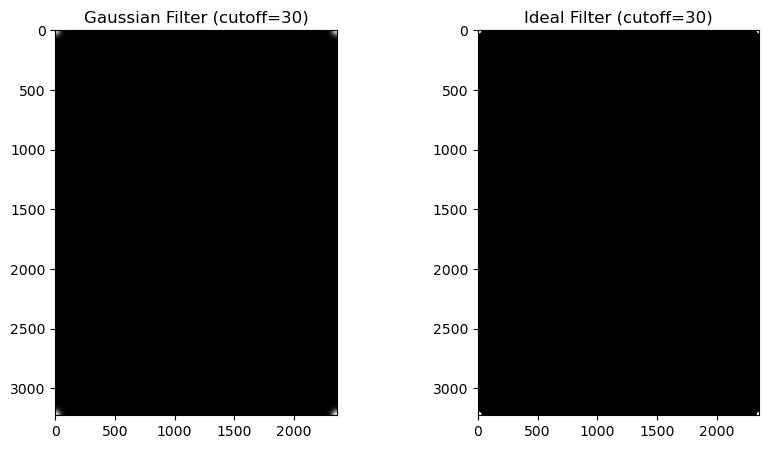

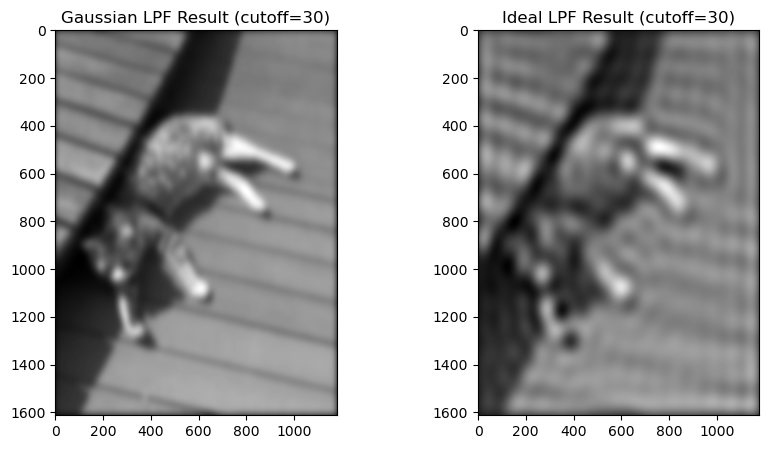

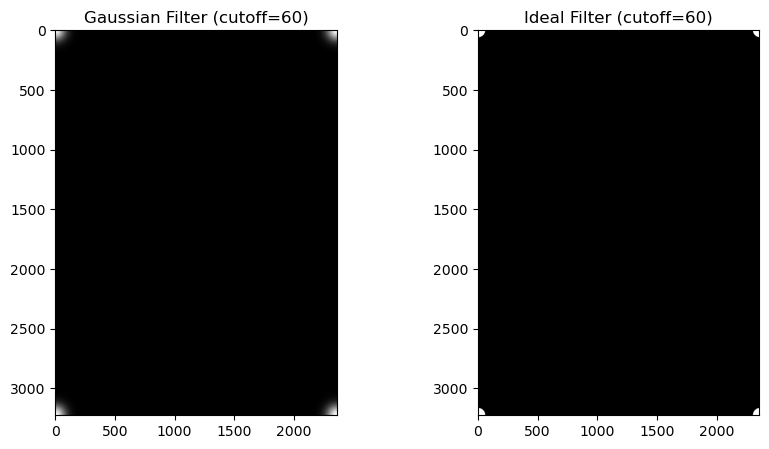

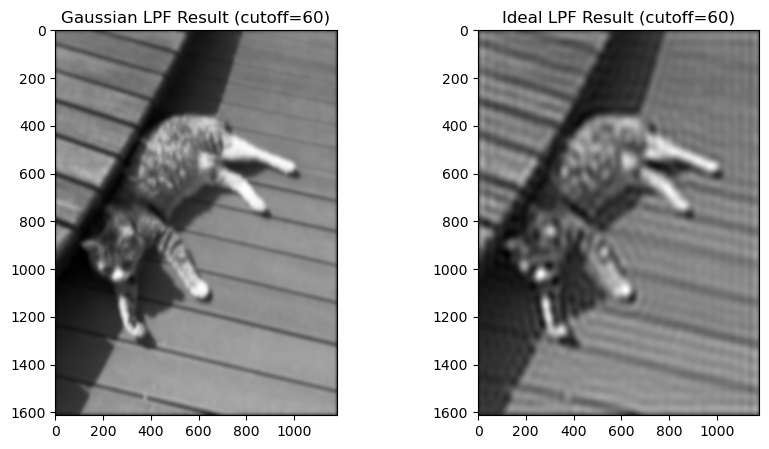

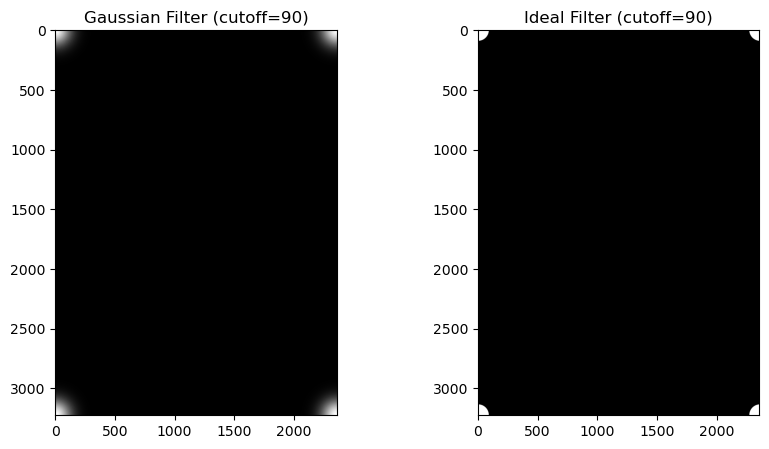

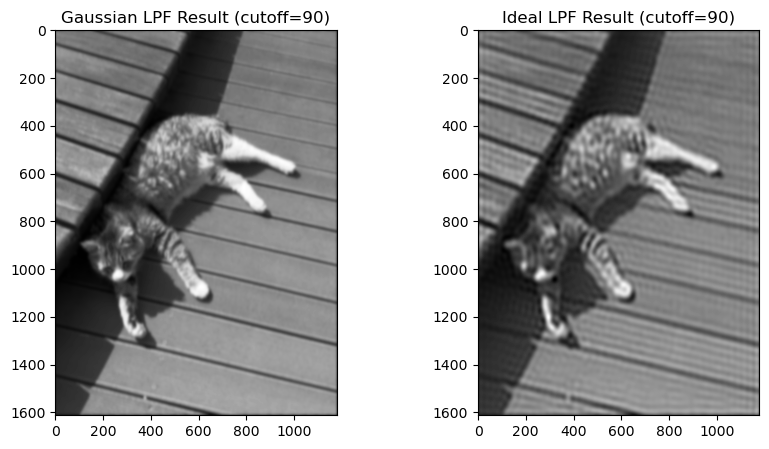

In [8]:
# --------------------------------------------------
# 5) 여러 cutoff(σ) 값에 대해 필터링 & 시각화
# --------------------------------------------------
cutoff_values = [10, 30, 60, 90]  # 원하는 값을 자유롭게 지정

for cutoff in cutoff_values:
    # (a) 가우시안 필터 생성
    gauss_filter = gaussian_lowpass_filter((P, Q), cutoff)
    # 주파수 영역에서 곱셈
    G_filtered_shifted = F_shifted * gauss_filter
    # 역 shift -> IFFT
    G_filtered = np.fft.ifftshift(G_filtered_shifted)
    g_img = np.fft.ifft2(G_filtered)
    g_img = np.real(g_img)  # 복소부는 거의 0이므로 실수화
    # 패딩 제거
    g_result = g_img[:M, :N]

    # (b) 이상적 필터 생성
    ideal_filter = ideal_lowpass_filter((P, Q), cutoff)
    I_filtered_shifted = F_shifted * ideal_filter
    I_filtered = np.fft.ifftshift(I_filtered_shifted)
    i_img = np.fft.ifft2(I_filtered)
    i_img = np.real(i_img)
    i_result = i_img[:M, :N]

    # --------------------------------------------------
    # 6) 결과 시각화
    # --------------------------------------------------
    # 주파수 스펙트럼 시각화(로그 스케일)
    # - 필터 자체도 log scale로 보면 값이 너무 작을 수 있으니
    #   단순히 imshow로 볼 수도 있음.
    gauss_filter_spectrum = np.fft.fftshift(gauss_filter)  # 시각화를 위해 중심으로 shift
    ideal_filter_spectrum = np.fft.fftshift(ideal_filter)
    
    # 그림 1) 가우시안 필터 vs. 이상적 필터
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(gauss_filter_spectrum, cmap='gray')
    plt.title(f'Gaussian Filter (cutoff={cutoff})')
    plt.subplot(1, 2, 2)
    plt.imshow(ideal_filter_spectrum, cmap='gray')
    plt.title(f'Ideal Filter (cutoff={cutoff})')
    plt.show()

    # 그림 2) 가우시안 결과 vs. 이상적 결과
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(g_result, cmap='gray')
    plt.title(f'Gaussian LPF Result (cutoff={cutoff})')
    plt.subplot(1, 2, 2)
    plt.imshow(i_result, cmap='gray')
    plt.title(f'Ideal LPF Result (cutoff={cutoff})')
    plt.show()



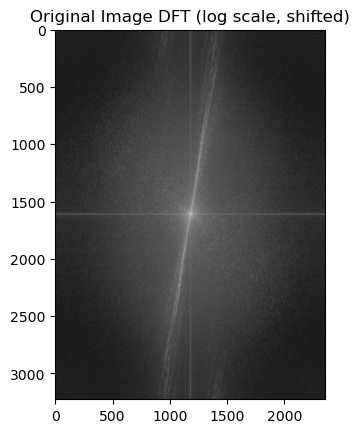

In [9]:
# --------------------------------------------------
# 추가) 원본 이미지의 푸리에 스펙트럼(교재 예시 코드처럼)
# --------------------------------------------------
spectrum = np.log(np.abs(F_shifted) + 1)  # +1로 log(0) 방지
plt.figure()
plt.imshow(spectrum, cmap='gray')
plt.title('Original Image DFT (log scale, shifted)')
plt.show()